# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

## Шаг 1. Изучение общей информации

In [1]:
import pandas as pd
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.display import display
from matplotlib import pyplot as plt
#Попытка открыть csv без указания разделителя.
#flats_spb = pd.read_csv('/datasets/real_estate_data.csv')
#print(flats_spb.head())
# Выяснили, что разделитель - \t

In [2]:
flats_spb = pd.read_csv('real_estate_data.csv', sep= '\\t', engine = 'python', encoding = 'utf-8')
print(flats_spb.info())
display(flats_spb.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

В правой части таблицы находится группа столбцов со значениями, рассчитанными автоматически по картографическим данным, пропуски в этих столбцах нужно изучить отдельно. Кроме этого, есть подозрительный столбец is_apartment, где пропуски составляют 90 %. Нужно изучить его уникальные значения. И еще есть два столбца, где пропусков настолько мало в отношении к выборке, что можно просто удалить соответствующие строки: столбцы floors_total и locality_name. Отсутствие данных по балконам возможно связано с тем, что нет самих балконов. Попробуем проверить эту гипотезу. В остальных случаях пропуски, видимо, нужно оставить как есть, поскольку не понятно, с чем можно связать их происхождение. Дату в столбце first_day_exposition нужно привести к типу datetime.

## Шаг 2. Предобработка данных

### Удаление строк

In [3]:
# Удаляем пропуски в столбцах floors_total и locality_name.
flats_spb = flats_spb.dropna(subset = ['floors_total', 'locality_name']).reset_index()
print(flats_spb.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 23565 non-null  int64  
 1   total_images          23565 non-null  int64  
 2   last_price            23565 non-null  float64
 3   total_area            23565 non-null  float64
 4   first_day_exposition  23565 non-null  object 
 5   rooms                 23565 non-null  int64  
 6   ceiling_height        14481 non-null  float64
 7   floors_total          23565 non-null  float64
 8   living_area           21700 non-null  float64
 9   floor                 23565 non-null  int64  
 10  is_apartment          2760 non-null   object 
 11  studio                23565 non-null  bool   
 12  open_plan             23565 non-null  bool   
 13  kitchen_area          21343 non-null  float64
 14  balcony               12090 non-null  float64
 15  locality_name      

### Столбец is_apartment

In [4]:
# Изучим уникальные значения столбца is_apartment
print(flats_spb.is_apartment.value_counts())
print()
# 90% NaNы, остальное почти все - False, только 50 значений True. Ничтожно мало.
# Избавимся от неинформативного столбца is_apartment
flats_spb = flats_spb.drop('is_apartment', axis = 'columns')
print(flats_spb.info())

False    2710
True       50
Name: is_apartment, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 23565 non-null  int64  
 1   total_images          23565 non-null  int64  
 2   last_price            23565 non-null  float64
 3   total_area            23565 non-null  float64
 4   first_day_exposition  23565 non-null  object 
 5   rooms                 23565 non-null  int64  
 6   ceiling_height        14481 non-null  float64
 7   floors_total          23565 non-null  float64
 8   living_area           21700 non-null  float64
 9   floor                 23565 non-null  int64  
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          21343 non-null  float64
 13  balcony               12090 non-null  float64
 14  locality

### Парки и водоемы

In [5]:
# Узнаем сколько каких уникальных значений столбца parks_around3000 у нас есть.
print(flats_spb.parks_around3000.value_counts())
print()
# Общее число квартир, рядом с которыми есть хотя бы один парк, подозрительно
# похоже на число ненулевых значений столбца parks_nearest. Проверим наше подозрение:
# посчитаем уникальные значения столбца parks_around3000 только для ненулевых значений parks_nearest
parks_without_nans = flats_spb[flats_spb.parks_nearest.isna() == False]
parks_stat = parks_without_nans.parks_around3000.value_counts()
print(parks_stat)

0.0    10039
1.0     5647
2.0     1736
3.0      643
Name: parks_around3000, dtype: int64

1.0    5647
2.0    1736
3.0     643
0.0       4
Name: parks_around3000, dtype: int64


### Парки. Вывод

10039 квартир (более половины выборки), у которых в радиусе 3 км нет ни одного парка, выглядят нереалистично, даже для такого каменного мешка, как Санкт-Петербург. Среди тех квартир, для которых расстояние до ближайшего парка посчитано, таких оказалось лишь 4. При этом все квартиры, для которых этот показатель больше 0, входят в число тех, для которых указано расстояние до ближайшего парка. Видимо, эти показатели связаны и оба рассчитывались автоматически, но для какой-то части данных они не рассчитывались, при этом в столбце parks_nearest NaNы были сохранены, а в столбце parks_around3000 заменены на нули. После чего добавили еще часть выборки, где сохраниись NaNы в обоих столбцах. Так или иначе, данные в столбце parks_around3000 сильно испорчены. Лучше избавиться от этого столбца. А NaNы в столбце parks_nearest оставим как есть.  

In [6]:
# Сделаем для водоемов, то же, что сделали для парков.
# Уникальные значения для количества водоемов в радиусе 3 км от квартиры
print(flats_spb.ponds_around3000.value_counts())
print()
#Уникальные значения для количества водоемов в радиусе 3 км от квартиры 
# для квартир с указанным расстоянием до ближайшего водоема
ponds_without_nans = flats_spb[flats_spb.ponds_nearest.isna() == False]
ponds_stat = ponds_without_nans.ponds_around3000.value_counts()
print(ponds_stat)

0.0    9029
1.0    5662
2.0    1883
3.0    1491
Name: ponds_around3000, dtype: int64

1.0    5662
2.0    1883
3.0    1491
Name: ponds_around3000, dtype: int64


### Водоемы. Вывод

В Петербурге таких квартир, где в радиусе 3 км нет водоемов, вероятно, не существует. В этой выборке все 9029  квартир, где в радиусе 3 км, нет водоемов, соотвтетствуют NaNам в столбце ponds_nearest. Значит, столбец ponds_around3000 тоже можно убрать.

In [7]:
# Удаляем столбцы parks_around3000 и ponds_around3000
flats_spb = flats_spb.drop(['ponds_around3000', 'parks_around3000'], axis = 'columns')

### Балконы

In [8]:
# Попробуем проверить гипотезу о том, что NaNы в "балконах" - это нули.
# Посчитаем сколько в среднем комнат для каждого значения по балконам
balconies_and_rooms = flats_spb.groupby('balcony')['rooms'].mean()
print(balconies_and_rooms)
print()
#Посчитаем, сколько в среднем комнат  квартир, где не указно количество балконов
balcony_nans = flats_spb[flats_spb.balcony.isna() == True]
balcony_nans_and_rooms = balcony_nans.rooms.mean()
print(balcony_nans_and_rooms)

balcony
0.0    2.127989
1.0    1.997373
2.0    1.842998
3.0    2.987654
4.0    2.642857
5.0    2.697368
Name: rooms, dtype: float64

2.1193899782135075


Среднее число комнат у квартир, где не указно количество балконов, очень близко к такому же показателю для квартир, где указано, что балконов нет. Заменим NaNы на нули

In [9]:
# Заполним нулями пропуски в "балконах".
flats_spb.balcony = flats_spb.balcony.fillna(0)
print(flats_spb.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 23565 non-null  int64  
 1   total_images          23565 non-null  int64  
 2   last_price            23565 non-null  float64
 3   total_area            23565 non-null  float64
 4   first_day_exposition  23565 non-null  object 
 5   rooms                 23565 non-null  int64  
 6   ceiling_height        14481 non-null  float64
 7   floors_total          23565 non-null  float64
 8   living_area           21700 non-null  float64
 9   floor                 23565 non-null  int64  
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          21343 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

### Замена дробных значений на целые

In [10]:
# Цену, исчисляемую миллионами, можно округлить до целого, а количество этажей и количество балконов
# само собой, нужно привести к типу int.
flats_spb.last_price = flats_spb.last_price.astype('int')
flats_spb.floors_total = flats_spb.floors_total.astype('int')
flats_spb.balcony = flats_spb.balcony.astype('int')

### Формат даты в столбце first_day_exposition

In [11]:
flats_spb.first_day_exposition = pd.to_datetime(flats_spb['first_day_exposition'])
print(flats_spb.dtypes)
print()
print(flats_spb.first_day_exposition.head())

index                            int64
total_images                     int64
last_price                       int32
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int32
living_area                    float64
floor                            int64
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int32
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_nearest                  float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]


### Площадь кухни и площадь жилых помещений 

In [12]:
# Попробуем проверить, можно ли считать пропуски в столбцах kitchen_area и living_area случайными.
# Возьмем медианное значение для total_area
area_median = flats_spb.total_area.median()
print(area_median)
# Теперь возьмем медианное значение общей площади для тех случаев, когда не указана площадь кухни
print(flats_spb[flats_spb.kitchen_area.isna() == True].total_area.median())
# И для тех, где не указана площадь жилых помещений
print(flats_spb[flats_spb.living_area.isna() == True].total_area.median())
# Показатели довольно близкие. Вероятно, пропуски в столбцах living_area
# можно считать случайными и заполнить их медианами.
flats_spb.living_area = flats_spb.fillna(flats_spb.living_area.median())
flats_spb.kitchen_area = flats_spb.fillna(flats_spb.kitchen_area.median())

52.0
46.0
53.0


### Количество дней размещения объявления

In [13]:
# NaNы в столбце days_exposition, возможно, связаны с тем, что эти квартиры так и не были проданы.
# Вероятно, можно просто убрать эти строки из статистики
flats_spb = flats_spb.dropna(subset = ['days_exposition']).reset_index()
print(flats_spb.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   level_0               20394 non-null  int64         
 1   index                 20394 non-null  int64         
 2   total_images          20394 non-null  int64         
 3   last_price            20394 non-null  int32         
 4   total_area            20394 non-null  float64       
 5   first_day_exposition  20394 non-null  datetime64[ns]
 6   rooms                 20394 non-null  int64         
 7   ceiling_height        12031 non-null  float64       
 8   floors_total          20394 non-null  int32         
 9   living_area           20394 non-null  object        
 10  floor                 20394 non-null  int64         
 11  studio                20394 non-null  bool          
 12  open_plan             20394 non-null  bool          
 13  kitchen_area    

### Итоги предобработки

У нас остались пропуски в столбце "высота потолка". Заменить их на характерные значения сложно - получится слишком много характерных значений, при этом для потолков центра города они не будут характерными, а будут слишком маленькими. Так мы рискуем исказить данные по центральным районам. Удалять пропуски тоже не стоит, это будет удаление почти половины выборки. Лучше всего не трогать этот столбец.
Также у нас сохранились пропуски в столбцах, полученных по картографическим данным. Здесь ситуация такая же - ни удалять слишком много ни наводнять выборку медианами, кажется, неправильно. Лучше оставить.

## Шаг 3. Подсчет и добавление данных в таблицу

### Цена квадратного метра, соотношения площадей

In [14]:
# Цена квадратного метра равняется цене квартиры деленной на площадь квартиры
flats_spb['price_meter_squared'] = flats_spb.last_price / flats_spb.total_area
# Соотношение жилой и общей площади
flats_spb['living_area_part'] = flats_spb.living_area / flats_spb.total_area
#Отношение площади кухни к общей площади
flats_spb['kitchen_area_part'] = flats_spb.kitchen_area / flats_spb.total_area

### Год, месяц и день размещения объявления

In [15]:
# Год
flats_spb['exposition_year'] = flats_spb['first_day_exposition'].dt.year
# Месяц
flats_spb['exposition_month'] = flats_spb['first_day_exposition'].dt.month
# День
flats_spb['exposition_weekday'] = flats_spb['first_day_exposition'].dt.weekday

### Этаж квартиры

In [16]:
# Сохдадим функцию для разделения этажей на категории "Первый", "Последний", "Другой"

def floor_type(row):
    if row.floor == 1:
        return "Первый"
    elif row.floor == row.floors_total:
        return "Последний"
    else:
        return "Другой"

# Применим функцию    
flats_spb['floor_category'] = flats_spb.apply(floor_type, axis = 1)

# Результаты выполнения Шага 3.
print(flats_spb.dtypes)
print()
display(flats_spb.head())

level_0                          int64
index                            int64
total_images                     int64
last_price                       int32
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int32
living_area                     object
floor                            int64
studio                            bool
open_plan                         bool
kitchen_area                    object
balcony                          int32
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_nearest                  float64
ponds_nearest                  float64
days_exposition                float64
price_meter_squared            float64
living_area_part                object
kitchen_area_part               object
exposition_year                  int64
exposition_month         

,level_0,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,...,parks_nearest,ponds_nearest,days_exposition,price_meter_squared,living_area_part,kitchen_area_part,exposition_year,exposition_month,exposition_weekday,floor_category
0,1,1,7,3350000,40.4,2018-12-04,1,NaN,11,1,...,NaN,NaN,81.0,82920.792079,0.0247525,0.0247525,2018,12,1,Первый
1,2,2,10,5196000,56.0,2015-08-20,2,NaN,5,2,...,90.0,574.0,558.0,92785.714286,0.0357143,0.0357143,2015,8,3,Другой
2,3,3,0,64900000,159.0,2015-07-24,3,NaN,14,3,...,84.0,234.0,424.0,408176.100629,0.0188679,0.0188679,2015,7,4,Другой
3,4,4,2,10000000,100.0,2018-06-19,2,3.03,14,4,...,112.0,48.0,121.0,100000.000000,0.04,0.04,2018,6,1,Другой
4,5,5,10,2890000,30.4,2018-09-10,1,NaN,12,5,...,NaN,NaN,55.0,95065.789474,0.164474,0.164474,2018,9,0,Другой


## Шаг 4. Исследовательский анализ данных

### Исследование каждого параметра в отдельности

### Площадь квартир

50.8


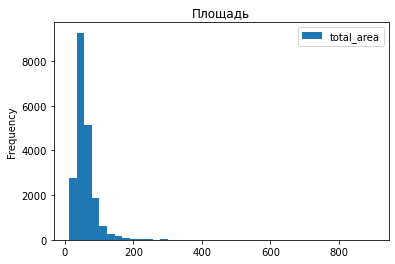

In [17]:
import matplotlib.pyplot as plt
print(flats_spb.total_area.median())
# Гистограмма распределения по общей площади, 40 корзин
flats_spb.plot(kind = 'hist', y = "total_area", bins = 40, title = "Площадь", legend = True)
plt.show()

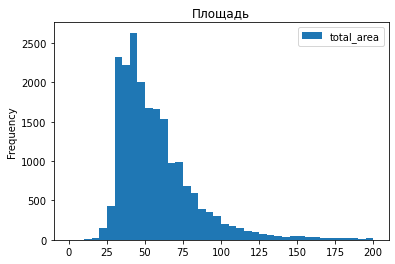

In [18]:
# То же самое для площадей в пределах 200 кв м
flats_spb.plot(kind = 'hist', y = "total_area", bins = 40, range = (0, 200), title = "Площадь", legend = True)
plt.show()

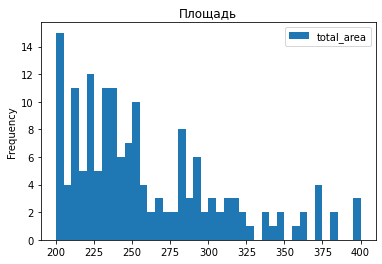

In [19]:
# От 200 до 400 кв м
flats_spb.plot(kind = 'hist', y = "total_area", bins = 40, range = (200, 400), title = "Площадь", legend = True)
plt.show()

Площадь подавляющего большинства квартир находится в диапазоне 30-100 кв.м. Медианное значение - 51 кв. м. Тем не менее число квартир, где площадь превышает 100 кв м. в этой выборке измеряется многими сотнями. Площадь больше 300 кв. м. имеют единицы квартир.

### Цена

4500000.0


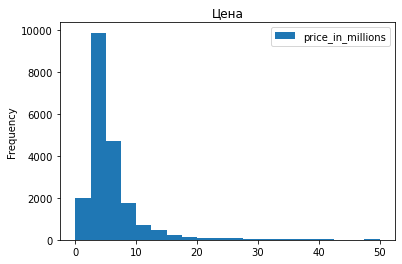

In [20]:
print(flats_spb.last_price.median())
flats_spb['price_in_millions'] = flats_spb['last_price'] / 1000000
flats_spb.plot(kind = 'hist', y = "price_in_millions", bins = 20, range = (0, 50), title = "Цена", legend = True)
plt.show()

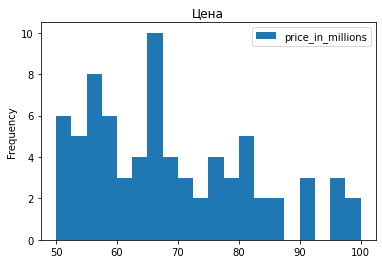

In [21]:
flats_spb.plot(kind = 'hist', y = "price_in_millions", bins = 20, range = (50, 100), title = "Цена", legend = True)
plt.show()

Цена на подавляющее большинство квартир находится в пределах 10 млн руб. Медианное значение 4.5 млн.

### Высота потолков

2.65


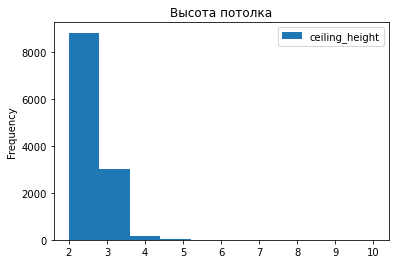

In [22]:
print(flats_spb.ceiling_height.median())
flats_spb.plot(kind = 'hist', y = "ceiling_height", range = (2, 10), title = "Высота потолка", legend = True)
plt.show()

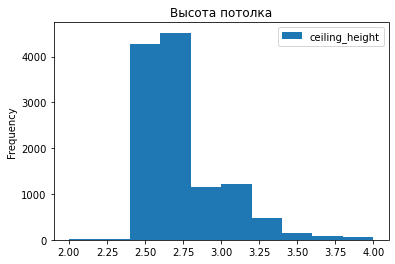

In [23]:
flats_spb.plot(kind = 'hist', y = "ceiling_height", range = (2, 4), title = "Высота потолка", legend = True)
flats_spb.ceiling_height.median()
plt.show()

Высота потолков в большинстве квартир - в диапазоне от 2.5 до 3 метров

### Количество комнат

1     7235
2     6871
3     4787
4      933
5      251
0      180
6       76
7       37
8       11
9        4
14       2
10       2
19       1
11       1
12       1
16       1
15       1
Name: rooms, dtype: int64


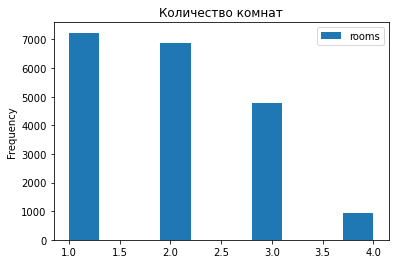

In [24]:
print(flats_spb.rooms.value_counts())
flats_spb.plot(kind = 'hist', y = "rooms", range = (1, 4), title = "Количество комнат", legend = True)
plt.show()

У подавляющего большинства квартир от одной до четырех комнат.

### Время продажи

95.0
180.7413945278023


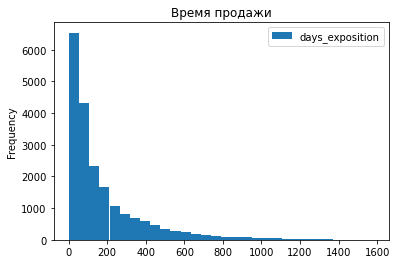

In [25]:
flats_spb.plot(kind = 'hist', y = "days_exposition", bins = 30, title = "Время продажи", legend = True)
print(flats_spb.days_exposition.median())
print(flats_spb.days_exposition.mean())

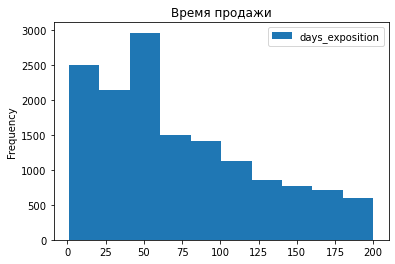

In [26]:
# Уберем редкие и выбивающиеся значения
flats_spb.plot(kind = 'hist', y = "days_exposition", range = (1, 200), title = "Время продажи", legend = True)
plt.show()

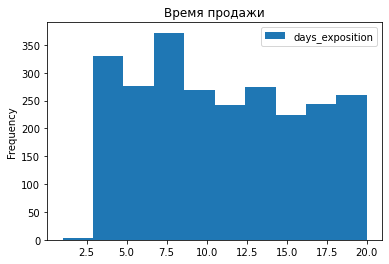

In [27]:
# Ищем, какое время продажи можно было бы считать необычно ранним
flats_spb.plot(kind = 'hist', y = "days_exposition", range = (1, 20), title = "Время продажи", legend = True)
plt.show()

Подавляющее большинство квартир продаются в течение года. Каждая вторая квартира продается в течение 3-х месяцев. Однако есть квартиры, ждущие покупателя по нескольку лет, чем и объясняется сдвиг среднего значения в сторону увеличения относительно медианы. Квартиру чаще покупают в первый или второй месяц после объявления. При этом продать квартиру в первые три дня - большая удача.

### Редкие значения

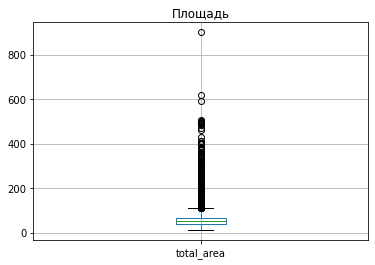

In [28]:
# Найдем редкие значения для площади
ax = flats_spb.boxplot('total_area')
ax.set_title ("Площадь")
plt.show()

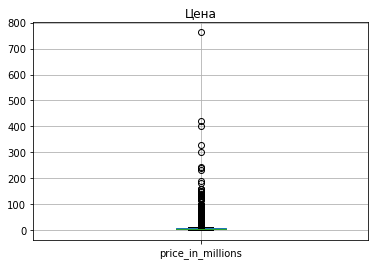

In [29]:
# Редкие значения для цены
ax = flats_spb.boxplot('price_in_millions')
ax.set_title ("Цена")
plt.show()

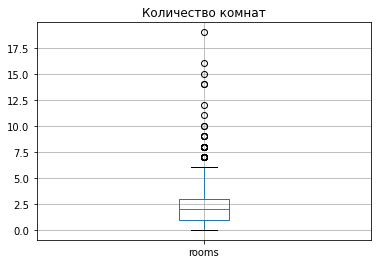

In [30]:
# Редкие значения для количества комнат
ax = flats_spb.boxplot('rooms')
ax.set_title ("Количество комнат")
plt.show()

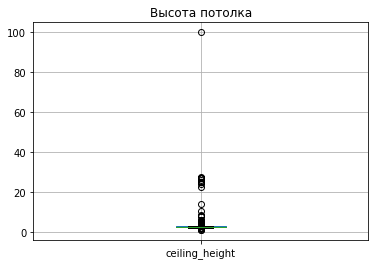

In [31]:
# Редкие значения для высоты потолков
ax = flats_spb.boxplot('ceiling_height')
ax.set_title ("Высота потолка")
plt.show()

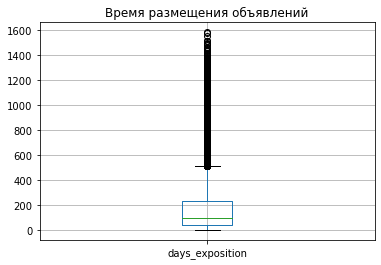

In [32]:
# Редкие значения для времени размещения объявлений
ax = flats_spb.boxplot('days_exposition')
ax.set_title ("Время размещения объявлений")
plt.show()

In [33]:
# Создадим таблицу без редких значений
no_seldom_vals = flats_spb.query('total_area < 150 and price_in_millions < 20 and rooms < 7 and ceiling_height > 2 and ceiling_height < 6 and days_exposition > 3 and days_exposition < 500')
print(no_seldom_vals.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10501 entries, 3 to 20391
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   level_0               10501 non-null  int64         
 1   index                 10501 non-null  int64         
 2   total_images          10501 non-null  int64         
 3   last_price            10501 non-null  int32         
 4   total_area            10501 non-null  float64       
 5   first_day_exposition  10501 non-null  datetime64[ns]
 6   rooms                 10501 non-null  int64         
 7   ceiling_height        10501 non-null  float64       
 8   floors_total          10501 non-null  int32         
 9   living_area           10501 non-null  object        
 10  floor                 10501 non-null  int64         
 11  studio                10501 non-null  bool          
 12  open_plan             10501 non-null  bool          
 13  kitchen_area    

### Зависимость цены от площади

0.6431195735060791
0.7606448639528209


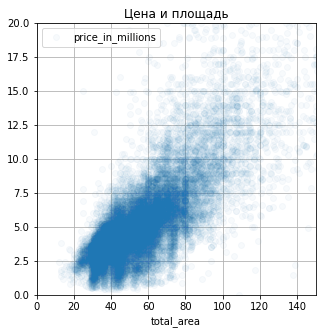

In [34]:
# Коэффициент корреляции для всей выборки
print(flats_spb.price_in_millions.corr(flats_spb.total_area))
#Коэффициент корреляции без выбивающихся значений
print(no_seldom_vals.price_in_millions.corr(no_seldom_vals.total_area))
flats_spb.plot(x = 'total_area', y = 'price_in_millions', title = "Цена и площадь", style = 'o', xlim =(0, 150), ylim = (0, 20), figsize =(5, 5), alpha=0.03, grid=True)
plt.show()

Цена зависит от площади. Чем больше площадь, тем реже попадаются низкие значения цены.

### Зависимость цены от количества комнат

0.3537739326599382
0.47693672425070516


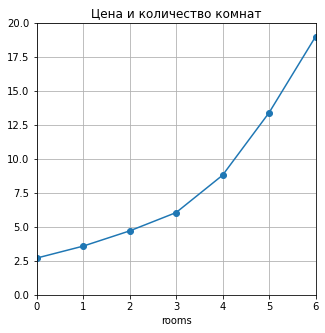

In [35]:
print(flats_spb.price_in_millions.corr(flats_spb.rooms))
print(no_seldom_vals.price_in_millions.corr(no_seldom_vals.rooms))
price_rooms = flats_spb.groupby("rooms")['price_in_millions'].median()
price_rooms.plot(x = 'rooms', y = 'price_in_millions', title = "Цена и количество комнат", style = 'o-',  xlim = (0, 6), ylim = (0, 20), figsize = (5, 5), grid= True)
plt.show()

Очевидна зависимость цены и от количества комнат: средняя цена возрастает по мере увеличения числа комнат. Коэффициент корреляции невысок, но график, построенный по медианным значениям, показывает, что чем больше комнат, тем выше в среднем цена.

### Зависимость цены от близости к центру

-0.19298575809090546
-0.34779639594049777


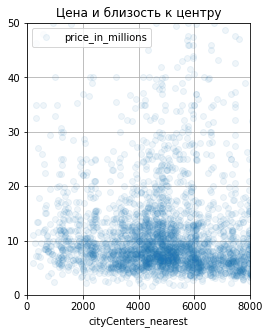

In [36]:
print(flats_spb.price_in_millions.corr(flats_spb.cityCenters_nearest))
print(no_seldom_vals.price_in_millions.corr(no_seldom_vals.cityCenters_nearest))
flats_spb.plot(x = 'cityCenters_nearest', y = 'price_in_millions', title = "Цена и близость к центру", style = 'o', xlim = (0, 8000), ylim = (0, 50), alpha = 0.07, figsize =(4, 5), grid=True)
plt.show()

Зависимость цены от удаленности от центра можно увидеть, если смотреть в пределах города (в радиусе 8 км).Так, если взять медианную цену в 4.6 млн, количество квартир, продаваемых по этой цене, заметно больше на расстоянии 4-6 км от центра, чем в радиусе 1-2 км от центра.  Подробнее центральне районы рассмотрены ниже. Низкий коэффициент корреляции, возможно, объясняется тем, что в выборке объединены разные населенные пункты.

### Зависимость цены от этажа

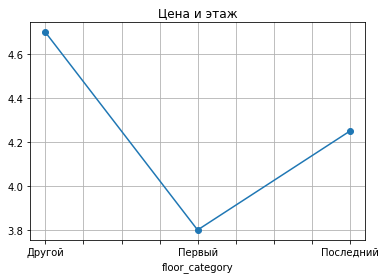

In [37]:
floor_price = flats_spb.groupby('floor_category')['price_in_millions'].median()
floor_price.plot(x = 'floor_category', y = 'price_in_millions', title = "Цена и этаж", style = 'o-', grid=True)
plt.show()

Квартиры на первом этаже в целом дешевле. На средних этажах - дороже, чем на последнем и первом.

### Зависимость цены от дня недели, месяца и года публикации объявления

In [38]:
weekday_price = flats_spb.groupby('exposition_weekday')['price_in_millions'].median()
month_price = flats_spb.groupby('exposition_month')['price_in_millions'].median()
year_price = flats_spb.groupby('exposition_year')['price_in_millions'].median()

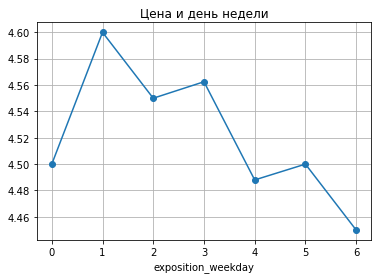

In [39]:
weekday_price.plot(x = "exposition_weekday", y = "price_in_millions", title = "Цена и день недели", style = 'o-', grid = True)
plt.show()

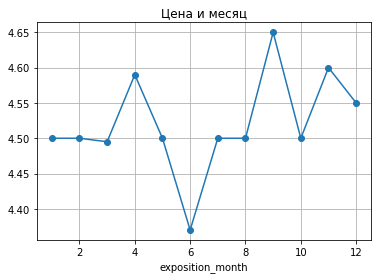

In [40]:
month_price.plot(x = "exposition_month", y = "price_in_millions", title = "Цена и месяц", style = 'o-', grid = True)
plt.show()

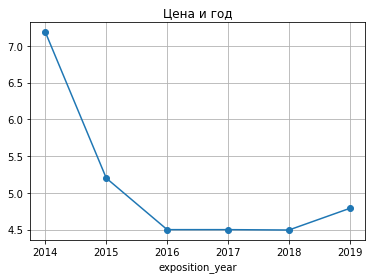

In [41]:
year_price.plot(x = "exposition_year", y = "price_in_millions", title = "Цена и год", style = 'o-', grid = True)
plt.show()

В 2015-2016 году цены снижались, 2016-2018 оставались на "дне", затем в 2019 немного выросли. Но до уровня 2014 очень далеко. С января по апрель - цены растут, с апреля по июнь резко падают, к концу лета возвращаются к средним показателям. Объявления, размещенные в начале недели выше, чем размещенные в конце. Может быть, по выходным объявления размещают владельцы, а по будним риэлторы?

In [42]:
# Матрица корреляции разных параметров
data = no_seldom_vals[['total_area', 'ceiling_height', 'rooms', 'cityCenters_nearest', 'price_in_millions']]
data.corr()

,total_area,ceiling_height,rooms,cityCenters_nearest,price_in_millions
total_area,1.000000,0.378208,0.793428,-0.183907,0.760645
ceiling_height,0.378208,1.000000,0.147382,-0.319950,0.460980
rooms,0.793428,0.147382,1.000000,-0.117523,0.476937
cityCenters_nearest,-0.183907,-0.319950,-0.117523,1.000000,-0.347796
price_in_millions,0.760645,0.460980,0.476937,-0.347796,1.000000


### Вывод по коэффициентам корреляции 

Коэффициенты корреляции показывают зависимость цены от площади и (вполне ожидаемо) площади от количества комнат. В то же время расчет этого показателя оказался не очень эффективен для отслеживания связи между ценой и другими параметрами, что связано, возможно, с тем, что в выборке смешаны разные населенные пункты. При этом графики, сделанные по медианным значениям, показывают связь между ценой, и, например, количеством комнат.

### 10 населенных пунктов, где больше всего объявлений

Коэффициент корреляции, видимо, не всегда помогает выявить зависимость одного параметра от другого. В данном случае редкие и выбивающиеся значения искажают картину. При этом графики, построенные на основании медианных значений, помогают выявить такую зависимость.

In [43]:
# Создадим срез нашей выборки по 10 городам с наибольшим количеством объявлений
# Для этого сначала посчитаем уникальные значения и возьмем первые 10: 
top_ten_localities = flats_spb.locality_name.value_counts().head(10)

# Теперь сделаем срез, используя индексы таблицы уникальных значений:
top_ten_localities_index = top_ten_localities.index
flats_of_top_ten_localities = flats_spb.query('locality_name in @top_ten_localities_index')
# Средняя цена квадратного метра для каждого из населенных пунктов получившейся таблицы:
mean_price_meter_squared = flats_of_top_ten_localities.groupby('locality_name')['price_meter_squared'].mean()
display(mean_price_meter_squared)

locality_name
Всеволожск            68570.615292
Выборг                57084.582948
Гатчина               67928.326990
Колпино               74865.364347
Пушкин               102074.629153
Санкт-Петербург      112438.937808
деревня Кудрово       92473.547576
посёлок Мурино        85738.945051
посёлок Парголово     89505.043917
посёлок Шушары        77872.600324
Name: price_meter_squared, dtype: float64

Дороже всего квадратный метр в Санкт-Петербурге, дешевле всего - в Выборге (почти вдвое дешевле, чем в Петербурге)

### Центр Петербурга

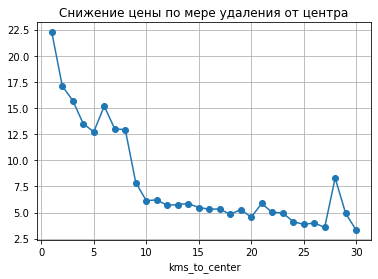

In [44]:
# Таблица только по Петербургу, полученная из соответствующего среза
only_petersburg = flats_spb.query('locality_name == "Санкт-Петербург"').reset_index(drop=True)
# Столбец с количеством километров. Окрушляем в большую сторону, чтобы получить
# значения больше 0. Т.е 300 метров - это в радиусе 1 км, 1300 - в радиусе  2 км итп.
only_petersburg['kms_to_center'] = only_petersburg.cityCenters_nearest // 1000 + 1 
# Средняя цена по километрам
mean_price_for_every_km = only_petersburg.groupby('kms_to_center')['price_in_millions'].mean()
mean_price_for_every_km.plot(x = 'kms_to_center', y = 'price_in_millions', title = "Снижение цены по мере удаления от центра", style = 'o-', grid=True)
plt.show()

На получившемся графике видно, что в пределах 4-8 километровой зоны цена колеблется: средняя цена для 8-го километра 12.5 млн, а для 4-го - примерно на 1 млн больше. Потом график резко идет вверх, с каждым километром в сторону центра добавляется по 2 млн к средней стоимости жилья. Особенно резкий рост между вторым и первым километрами - сразу на 5 млн.

### Площадь квартиры в центре города

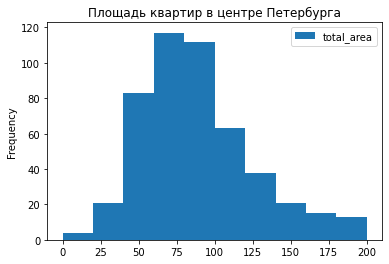

In [45]:
# Центральную зону Петербурга определим как радиус в 3 км:
center_spb = only_petersburg.query('kms_to_center < 4').reset_index(drop=True)
center_spb.plot(y = 'total_area', title = 'Площадь квартир в центре Петербурга', kind= "hist", range= (0, 200))
center_spb.total_area.median()
plt.show()

Медианная площадь квартиры для центральных районов - 87 кв.м. Для города в целом - 52. В целом в городе площадь в 100 кв.м. встречается довольно редко, в центре же это довольно распространенное явление.

### Цены в центре города 

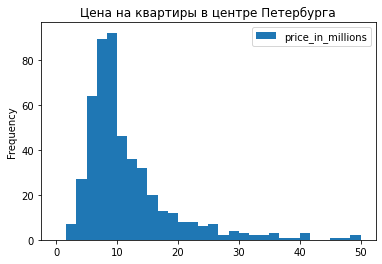

In [46]:
center_spb.plot(y = 'price_in_millions', title = 'Цена на квартиры в центре Петербурга', kind= "hist", bins = 30, range= (0, 50))
center_spb.price_in_millions.median()
plt.show()

Цены на недвижимость в центре в два раза выше, чем в среднем по городу. Цена в 10 млн для города в целом - редкость, для центра - медианное значение.

### Потолки в центре города

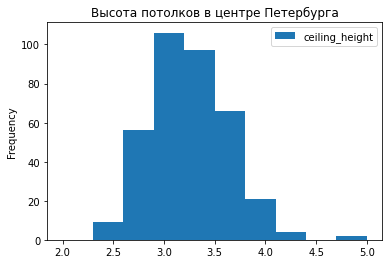

In [47]:
center_spb.plot(y = 'ceiling_height', title = 'Высота потолков в центре Петербурга', kind= "hist", range= (2, 5))
center_spb.ceiling_height.median()
plt.show()

Потолки в центре повыше, чем в среднем в городе. Медианные значения 3.2 и 2.6 соответственно. Потолки выше трех с половиной метров довольно редки в городе, но в центре они встречаются часто.

### Количество комнат в квартирах центра города

2     153
3     150
4      95
5      43
1      42
6      22
7       6
8       4
0       3
14      1
11      1
Name: rooms, dtype: int64


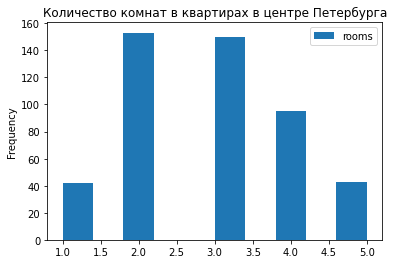

In [48]:
print(center_spb.rooms.value_counts())
center_spb.plot(y = 'rooms', title = 'Количество комнат в квартирах в центре Петербурга', kind= "hist", range= (1, 5))
plt.show()

Однокомнатная квартира - в среднем самый распространенный вид жилья, но в центре Петербурга такую сложно будет найти. Двух-, трех-, четырех- и даже пятикомнатные квартиры в центре попадаются чаще. Самый распространенный вид жилья в центре трехкомнатные квартиры, их там более, чем в три раза больше, чем однокомнатных (тогда как в среднем трехкомнатных квартир в полтора раза меньше, чем однокомнатных).

### Время размещения объявлений в центре города

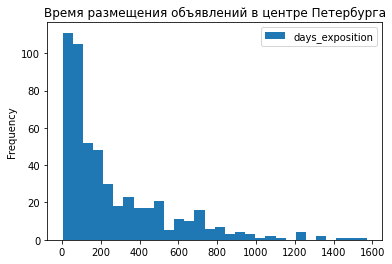

In [49]:
center_spb.plot(y = 'days_exposition', title = 'Время размещения объявлений в центре Петербурга', kind= "hist", bins = 30)
center_spb.days_exposition.median()
plt.show()

Чтобы продать квартиру в центре нужно больше времени, чем в среднем по городу. Медианное время - почти пять месяцев (в среднем по городу - три), нередки случаи, когда покупателя нужно ждать больше полугода.

### Зависимость цены от площади для центра города

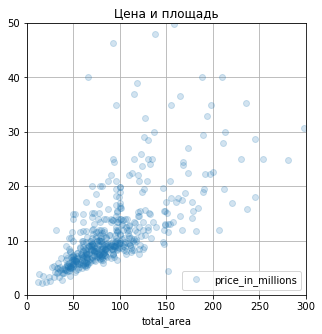

In [50]:
center_spb.plot(x = 'total_area', y = 'price_in_millions', title = "Цена и площадь", style = "o", xlim = (0, 300), ylim = (0, 50), alpha=0.2, figsize= (5,5), grid=True)
plt.show()

Зависимость цены от площади для центра также очевидна, как и для города в целом. Разница лишь в самих показателях площади и цен.

### Зависимость цены от близости к центру в центральных районах

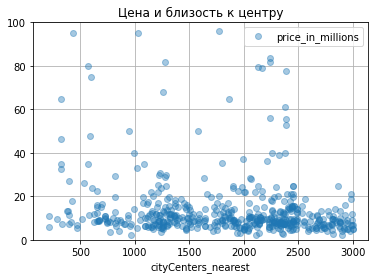

In [51]:
center_spb.plot(x = 'cityCenters_nearest', y = 'price_in_millions', title = "Цена и близость к центру", style = 'o', ylim = (0, 100), alpha = 0.4, grid=True)
plt.show()

Зависимость цены от расстояния до центра выглядит так же, как для города в целом. Квартир подешевле больше на втором-третьем километре больше, чем на первом.

### Зависимость цены от количества комнат в центре города

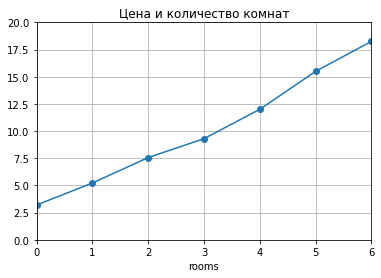

In [52]:
center_rooms_price = center_spb.groupby('rooms')['price_in_millions'].median()
center_rooms_price.plot(x = 'rooms', y = 'price_in_millions', title = "Цена и количество комнат", style = 'o-', xlim = (0, 6), ylim = (0, 20), grid = True)
plt.show()

Зависимость цены от числа комнат в центре тоже заметна, но выглядит более линейно, чем в городе в среднем. Возможно, дело в том, что начиная с трех-четырех-комнатных квартир доля дорогих центральных районов в общей выборке резко возрастает, поэтому график зависимости цены от количества для города в целом загибался вверх. В целом же зависимость цены от количества комнат для одного и того же района должна выглядеть линейно, как на этом графике.

In [53]:
# Матрица корреляции для разных параметров для центра города
data2 = center_spb[['total_area', 'rooms', 'kms_to_center', 'ceiling_height', 'price_in_millions']]
data2.corr()

,total_area,rooms,kms_to_center,ceiling_height,price_in_millions
total_area,1.000000,0.748065,-0.089483,0.199717,0.596426
rooms,0.748065,1.000000,-0.056539,0.042321,0.255129
kms_to_center,-0.089483,-0.056539,1.000000,-0.007408,-0.064851
ceiling_height,0.199717,0.042321,-0.007408,1.000000,0.181173
price_in_millions,0.596426,0.255129,-0.064851,0.181173,1.000000


Коэффициент корреляции не показывает значимых взаимосвязей, которые были видны на всех графиках, за исключением зависимости цены от площади. С чем это связано, не знаю, но может быть, влияние факторов на цены не столь линейно, чтобы коэффициент мог быть средством адекватной оценки. Так, например, на графике было видно как резко растет цена по мере приближения к центру в центральных районах. Но коэффициент корреляции этих двух показателей для центральных районов - 0.06.


### Зависимость цены от этажа в центре

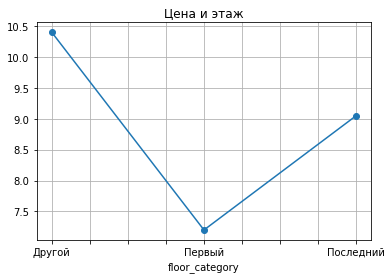

In [54]:
center_floors = center_spb.groupby('floor_category')['price_in_millions'].median()
center_floors.plot(x = 'floor_category', y = 'price_in_millions', title = "Цена и этаж", style = 'o-', grid = True)
plt.show()

Та же зависимость, что и для города в целом. Первый этаж дешевле всех, дороже всего - средние этажи.

### Зависимость цены от дня недели, месяца и года объявления

In [55]:
weekday_price_center = center_spb.groupby('exposition_weekday')['price_in_millions'].median()
month_price_center = center_spb.groupby('exposition_month')['price_in_millions'].median()
year_price_center = center_spb.groupby('exposition_year')['price_in_millions'].median()

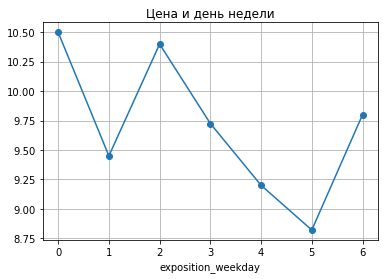

In [56]:
weekday_price_center.plot(x = 'exposition_weekday', y = 'price_in_millions', title = "Цена и день недели", style = 'o-', grid = True)
plt.show()

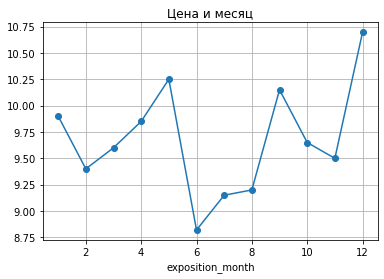

In [57]:
month_price_center.plot(x = 'exposition_month', y = 'price_in_millions', title = "Цена и месяц", style = 'o-', grid = True)
plt.show()

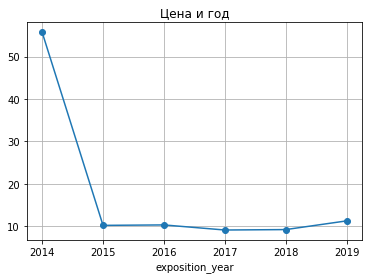

In [58]:
year_price_center.plot(x = 'exposition_year', y = 'price_in_millions', title = "Цена и год", style = 'o-', grid = True)
plt.show()

Зависимости цены от дня недели, месяца и года размещения объявления выглядят для центра точно так же, как для города в целом. Падение цен в 2014 году, небольшой отскок в 2019, сезонное повышение цены в начале года, падение к лету, возвращение к средним значениям во второй половине года. В первой половине недели размещют более дорогие объявления, чем во второй.

### Шаг 5. Общий вывод

К числу основных факторов, влияющих на цену квартиры, можно отнести близость к центру, площадь, число комнат, высоту потолков, этаж, сезонные колебания спроса и его общий уровень в данном году. Такие факторы как площадь, высота потолков и число комнат, связаны с фактором месторасположения. В центре больше старого фонда - больших многокомнатных квартир с высокими потолками. В радиусе одного километра от центра цены особенно высоки, очевидно, имеет значение и вида из окна. Вероятно, квартира с видом на Исакиевский собор будет стоить дороже, чем с видом на Московский вокзал.